In [31]:
import pandas as pd
import scanpy as sc
import anndata as ad
import torch 
from torch.utils import data
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

In [42]:
from scInferCode.utils import *
from scInferCode.model import *

In [33]:
rna = sc.read_h5ad('./scInferData/PancreasTask/gko.h5ad')
protein = sc.read_h5ad('./scInferData/PancreasTask/protein.h5ad')

In [34]:
rna = rna[((rna.obs['cell_type'] == 'beta') | (rna.obs['cell_type'] == 'alpha') | (rna.obs['cell_type'] == 'delta'))
]

In [35]:
rna_em = sc.read_h5ad('./scInferData/PancreasTask/gko_embeddings.h5ad')
protein_em = sc.read_h5ad('./scInferData/PancreasTask/protein_embeddings.h5ad')

In [36]:
threshold = 0.75
min_prt_num = 1
screen_num = 10
temperature = 5

In [37]:
candidate_df, black_list = screen_candidate(rna_em, protein_em, threshold, screen_num, min_prt_num)

There are 344 rna cells cannot find candidate protein cells.


In [38]:
rna = rna[~rna.obs_names.isin(black_list)]

In [39]:
rna.obs = rna.obs.merge(candidate_df[[f'match_{screen_num}_largest']], left_index=True, right_index=True, how='left')

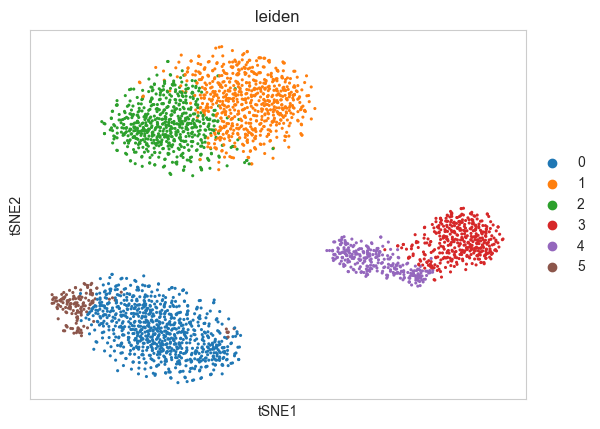

In [40]:
rna_hv = add_cluster_info(rna, resolution=1, cluster_by='highly_variable')

In [41]:
match_list_df, protein_df, train_dataset, test_dataset = make_infer_dataset(rna_hv, screen_num, protein, valid_ratio=0.3)

/home/yuzhi/project2024/scInfer/scInferCode/utils.py:279: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = ids.groupby(by)


In [43]:
input_size = train_dataset.get_size() 
batch_size = 300
num_epochs = 100
lr = 0.5
patience = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InferNetwork(input_size,output_size=screen_num, t=temperature).to(device)
criterion = ClusterLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [44]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, shuffle=False)

model: InferNetwork | lr: 0.5 | batch_size: 300
lr: 0.450000
epoch:0| Train Loss: 0.02024820718152438 | Test Loss: 3.8502406173689305
epoch:1| Train Loss: 0.014035845577269513 | Test Loss: 3.3389602937499463
epoch:2| Train Loss: 0.0074883481001876305 | Test Loss: 3.3306557773627774
epoch:3| Train Loss: 0.007220241885918837 | Test Loss: 3.330159766221282
epoch:4| Train Loss: 0.007176395568570321 | Test Loss: 3.353386861170948
epoch:5| Train Loss: 0.006544473338138319 | Test Loss: 3.1340800870524803
epoch:6| Train Loss: 0.006495649271118708 | Test Loss: 1.6862015970190323
epoch:7| Train Loss: 0.006368476163602904 | Test Loss: 1.3013697549880663
epoch:8| Train Loss: 0.0063369062713453965 | Test Loss: 0.8120935285130657
epoch:9| Train Loss: 0.006319418871044889 | Test Loss: 0.8756590768874803
lr: 0.405000
epoch:10| Train Loss: 0.006461091164855975 | Test Loss: 1.0036772718544718
epoch:11| Train Loss: 0.006298320846698521 | Test Loss: 0.9502670291226467
epoch:12| Train Loss: 0.0065187943739

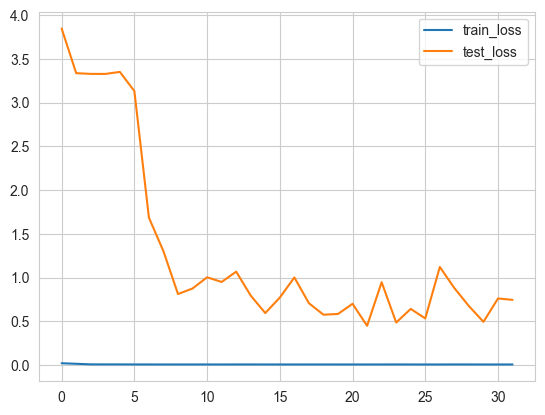

In [45]:
model = train_infer(train_loader, test_loader, model, criterion, num_epochs, patience, optimizer, batch_size, device)

In [46]:
model_path = f'./scInferData/PancreasTask/PancreasTaskInfer.pth'

In [47]:
torch.save(model.state_dict(), model_path)

In [48]:
model = InferNetwork(input_size,output_size=screen_num, t=temperature).to(device)

In [49]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [50]:
model.eval()

InferNetwork(
  (features): Sequential(
    (0): Conv1d(10, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=100, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [51]:
rna_res = infer_protein(protein_df, match_list_df, device, model, protein, rna, screen_num)

In [55]:
rna.write('./scInferData/PancreasTask/final_inference.h5ad')